### Homework

### Dataset


In this homework, we will use Credit Card Data from book "Econometric Analysis".

Here's a wget-able link:

wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
The goal of this homework is to inspect the output of different evaluation metrics by creating a classification model (target column card).

In [1]:
# Import libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import random

from tqdm.auto import tqdm

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


### Preparation

- Create the target variable by mapping yes to 1 and no to 0.
- Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split funciton for that with random_state=1

In [2]:
df = pd.read_csv('/Users/admin/Documents/Data Science/ml-zoomcamp/Module 4 Evaluation Metrics for Classification/AER_credit_card_data.csv')
print(len(df))

1319


In [3]:
# Create the target variable by mapping yes to 1 and no to 0.
df['card'] = (df['card'] == 'yes').astype(int)

In [4]:
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,1,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,1,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,1,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,1,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,1,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


### Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split funciton for that with random_state=1

In [5]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

del df_train['card']
del df_val['card']
del df_test['card']

In [6]:
len(df_train), len(df_val), len(df_test)

(791, 264, 264)

In [7]:
len(y_train), len(y_val), len(y_test)

(791, 264, 264)

In [8]:
# List of numerical variables
numerical = [col for col in df.columns if df[col].dtypes != 'object']
categorical = [col for col in df.columns if df[col].dtypes == 'object']

# Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

- For each numerical variable, use it as score and compute AUC with the card variable.
- Use the training dataset for that.

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['expenditure'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- reports
- dependents
- active
- share

In [9]:
numerical

['card',
 'reports',
 'age',
 'income',
 'share',
 'expenditure',
 'dependents',
 'months',
 'majorcards',
 'active']

In [10]:
for col in numerical:
    auc_scores = roc_auc_score(df['card'], df[col])
    print(col, ':', auc_scores)

card : 1.0
reports : 0.28219862090829834
age : 0.4986245409632507
income : 0.5888896594541755
share : 0.9898054212570342
expenditure : 0.9897360703812317
dependents : 0.4742278935827323
months : 0.48211738131092974
majorcards : 0.5499111648305197
active : 0.5824680985971309


Among four highlighted variables, share has the highest auc

# Training the model
From now on, use these columns only:

["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [11]:
use_columns = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

In [12]:
df_train_use = df_train[use_columns]
df_val_use = df_val[use_columns]

In [13]:
len(df_train_use), len(df_val_use)

(791, 264)

In [14]:
df_train_use.head()

,reports,age,income,share,expenditure,dependents,months,majorcards,active,owner,selfemp
0,3,40.50000,4.0128,0.000299,0.00000,1,12,1,17,no,no
1,1,32.33333,6.0000,0.000200,0.00000,4,18,1,4,yes,no
2,1,29.16667,2.2000,0.038205,69.79333,0,49,1,7,no,no
3,1,54.66667,7.2900,0.106536,647.20670,2,78,1,9,yes,no
4,0,25.00000,3.3984,0.000353,0.00000,2,29,0,4,yes,no


In [15]:
# Instantiate the DictVectorizer for ohe
dv = DictVectorizer(sparse=False)

# Train and fit DictVectorizer for both train and validation date subset
train_dict = df_train_use.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val_use.to_dict(orient='records')
X_val = dv.transform(val_dict)

In [16]:
# Training the model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

# Fit the model
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [17]:
# Model prediction on validation dataset
y_pred = model.predict_proba(X_val)[:, 1]

In [18]:
card_decision = (y_pred >= 0.5)
(y_val == card_decision).mean()

0.9696969696969697

In [19]:
accuracy_score(y_val, y_pred >= 0.5)

0.9696969696969697

In [20]:
# Confusion matrix
# actual churning and not churning
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [21]:
# Prediction
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)


In [22]:
# Getting true positive, true negative, false positive, false negative
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [23]:
print('tp :', tp)
print('tn :', tn)
print('fp :', fp)
print('fn :', tn)

tp : 204
tn : 52
fp : 1
fn : 52


In [24]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[ 52,   1],
       [  7, 204]])

In [25]:
# Precision is the percentage or number of positive predictions that are correct or eventually positive (i.e. TP/(TP+FP))
p = tp / (tp + fp)
p

0.9951219512195122

In [26]:
# percentage of correctly identified positive examples
r = tp / (tp + fn)
r

0.966824644549763

In [27]:
# TPR is the ratio of making a correct positive prediction to all positive outcome. The goal her is to maximize TPR
tpr = tp / (tp + fn)
tpr

0.966824644549763

In [28]:
# FPR is the ratio of FP (i.e wrongly predicting negative as positive) to all the negative occurence. 
#The goal is to minimize FPR
fpr = fp / (fp + tn)
fpr

0.018867924528301886

# Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.615
- 0.515
- 0.715
- 0.995

In [29]:
# Calculating area under the curve
roc_auc_score(y_val, y_pred).round(3)

0.995

# Question 3

Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
For each threshold, compute precision and recall
Plot them
At which threshold precision and recall curves intersect?

- 0.1
- 0.3
- 0.6
- 0.8

In [30]:
import decimal

def float_range(start, stop, step):
  while start < stop:
    yield float(start)
    start += decimal.Decimal(step)

print(list(float_range(0, 1, '0.01')))

[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]


In [31]:
# Getting contents of confusion matrix as different threasholds
scores = []

thresholds = float_range(0, 1, '0.01')

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    
    
    scores.append((t, tp, fp, fn, tn, p, r))

In [32]:
# Putting the scores into datafram
columns = ['threshold', 'tp', 'fp', 'fn', 'tn', 'p', 'r']
df_scores = pd.DataFrame(scores, columns=columns)

In [33]:
df_scores.head()

,threshold,tp,fp,fn,tn,p,r
0,0.00,211,53,0,0,0.799242,1.0
1,0.01,211,34,0,19,0.861224,1.0
2,0.02,211,31,0,22,0.871901,1.0
3,0.03,211,24,0,29,0.897872,1.0
4,0.04,211,22,0,31,0.905579,1.0


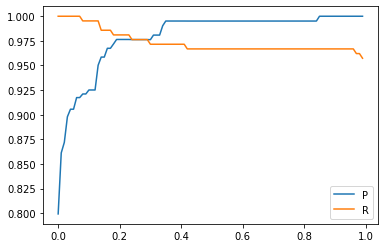

In [34]:
plt.plot(df_scores.threshold, df_scores['p'], label='P')
plt.plot(df_scores.threshold, df_scores['r'], label='R')
plt.legend()

In [35]:
# Getting contents of confusion matrix as different threasholds
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    
    scores.append((t, tp, fp, fn, tn, p, r))

In [36]:
# Putting the scores into datafram
columns = ['threshold', 'tp', 'fp', 'fn', 'tn', 'p', 'r']
df_scores = pd.DataFrame(scores, columns=columns)

In [37]:
df_scores.head()

,threshold,tp,fp,fn,tn,p,r
0,0.00,211,53,0,0,0.799242,1.0
1,0.01,211,34,0,19,0.861224,1.0
2,0.02,211,31,0,22,0.871901,1.0
3,0.03,211,24,0,29,0.897872,1.0
4,0.04,211,22,0,31,0.905579,1.0


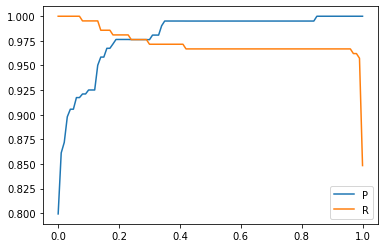

In [38]:
plt.plot(df_scores.threshold, df_scores['p'], label='P')
plt.plot(df_scores.threshold, df_scores['r'], label='R')
plt.legend()

Precision and Recall intersect at 0.3 threashold

# Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F1 = 2 * P * R / (P + R)

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.1
- 0.4
- 0.6
- 0.7

In [39]:
# Getting contents of confusion matrix as different threasholds
F1_scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    F1 = 2 * p * r / (p + r)
    
    F1_scores.append((t, tp, fp, fn, tn, p, r, F1))

In [40]:
# Putting the scores into datafram
columns = ['threshold', 'tp', 'fp', 'fn', 'tn', 'p', 'r', 'F1']
df_F1_scores = pd.DataFrame(F1_scores, columns=columns)

In [41]:
df_F1_scores

,threshold,tp,fp,fn,tn,p,r,F1
0,0.00,211,53,0,0,0.799242,1.000000,0.888421
1,0.01,211,34,0,19,0.861224,1.000000,0.925439
2,0.02,211,31,0,22,0.871901,1.000000,0.931567
3,0.03,211,24,0,29,0.897872,1.000000,0.946188
4,0.04,211,22,0,31,0.905579,1.000000,0.950450
5,0.05,211,22,0,31,0.905579,1.000000,0.950450
6,0.06,211,19,0,34,0.917391,1.000000,0.956916
7,0.07,211,19,0,34,0.917391,1.000000,0.956916
8,0.08,210,18,1,35,0.921053,0.995261,0.956720
9,0.09,210,18,1,35,0.921053,0.995261,0.956720


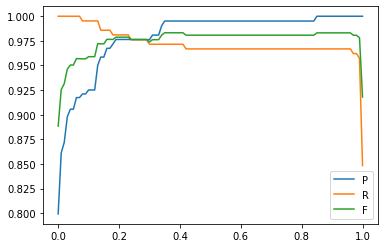

In [42]:
plt.plot(df_F1_scores.threshold, df_F1_scores['p'], label='P')
plt.plot(df_F1_scores.threshold, df_F1_scores['r'], label='R')
plt.plot(df_F1_scores.threshold, df_F1_scores['F1'], label='F')
plt.legend()

F1 is at the maximum at 0.40

# Question 5

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)

- Iterate over different folds of df_full_train
- Split the data into train and validation
- Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
- Use AUC to evaluate the model on validation

How large is standard devidation of the AUC scores across different folds?

- 0.003
- 0.014
- 0.09
- 0.24

In [43]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [44]:
# train_idx, val_idx = next(kfold.split(df_full_train))

In [45]:
# len(train_idx), len(val_idx)

In [46]:
# df_full_train_use = df_full_train[use_columns]

In [47]:
# df_train = df_full_train_use.iloc[train_idx]
# df_val = df_full_train_use.iloc[val_idx]

In [48]:
# y_train = df_full_train.card.iloc[train_idx]
# y_val = df_full_train.card.iloc[val_idx]

In [49]:
# Training function

def train(df_train, y_train):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [50]:
def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred


In [51]:
scores = []

for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    df_full_train_use = df_full_train[use_columns]
    df_train = df_full_train_use.iloc[train_idx]
    df_val = df_full_train_use.iloc[val_idx]

    y_train = df_full_train.card.iloc[train_idx]
    y_val = df_full_train.card.iloc[val_idx]

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

0it [00:00, ?it/s]

In [52]:
scores

[0.9941860465116279,
 0.9941176470588236,
 0.9943346508563901,
 0.9996107939802803,
 1.0]

In [53]:
print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.996 +- 0.003


It is 0.003 large

# Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

Iterate over the following C values: [0.01, 0.1, 1, 10]
Initialize KFold with the same parameters as previously
Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [55]:
# Training function

def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [56]:
# Tuning the parameter of our logistic model i.e. C
n_splits = 5

for C in tqdm([0.01, 0.1, 1, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
        df_full_train_use = df_full_train[use_columns]
        df_train = df_full_train_use.iloc[train_idx]
        df_val = df_full_train_use.iloc[val_idx]

        y_train = df_full_train.card.iloc[train_idx]
        y_val = df_full_train.card.iloc[val_idx]

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

C=0.01 0.996 +- 0.003


0it [00:00, ?it/s]

C=0.1 0.996 +- 0.003


0it [00:00, ?it/s]

C=1 0.996 +- 0.003


0it [00:00, ?it/s]

C=10 0.996 +- 0.003


0.01